In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams["font.size"] = 14
import glob
import sdf
import tqdm
from epoch_viz.viz import EpochViz

In [2]:
DATA_DIR = "SG/p_4"

In [3]:
ez = EpochViz(DATA_DIR)

In [4]:
ez.print_info()

Here are the some infomation about the data in the directory: SG/p_4

Total number of sdf files: 1669
------------------------------------------------------------
Available data inside the sdf files:
	Ex	Ey	Ez	Ne	N
------------------------------------------------------------
Input deck information:
	Wavelength (m): 1.0000e-06
	Laser Width (tau): 2.0000e+01
	Max Time (tau): 4.0000e+01
	Dump Time Step (s): 8.0000e-17
	Normalized Vector Potential: 5.0000e-01
	Density Factor: 4.0000e+00
	Number of Grid Points: 1.6000e+04
	Minimum X (wavelength): -2.0000e+01
	Maximum X (wavelength): 2.0000e+01
	Thickness of Plasma (wavelength): 1.0000e+00
	Particles per Cell: 1.0000e+02
	Start Position of Plasma (wavelength): 0.0000e+00
	Temperature of Plasma (eV): 5.0000e+01
------------------------------------------------------------
Calculated Parameters:
	Box Size (m): 4.0000e-05
	Grid Spacing (m): 2.5000e-09
	Time Step (s): 7.9222e-18
	Run Time (s): 1.3343e-13
	Laser Frequency (Hz): 1.8837e+15
	Laser W

In [7]:
ez.deck_info

{'LAMBD': 1e-06,
 'LAS_TIME': 20,
 'T_MAX': 40,
 'DT': 8e-17,
 'A0': 0.5,
 'FACTOR': 4,
 'NX': 16000,
 'X_MIN': -20,
 'X_MAX': 20,
 'THICKNESS': 1,
 'PPC': 100,
 'START': 0,
 'TEMP': 50}

In [8]:
ez.calculated_parameters

{'box_size': 3.9999999999999996e-05,
 'dx': 2.4999999999999996e-09,
 'dt': 7.922196774685953e-18,
 'runtime': 1.3342563807926081e-13,
 'omega0': 1883651567308853.2,
 'tau': 3.3356409519815205e-15,
 'nc': 1.114854217985065e+27,
 'pulse_width': 6.671281903963041e-14,
 'ne': 4.45941687194026e+27,
 'temperature_ev': 50,
 'temperature': 580226.1027303315,
 'lambdaD': 7.871638401513034e-10,
 'vth': 2965484.8024597163,
 'omega_max': 41.69551189976901}

Time range is not compatible. Loading data...


Loading Data...: 100%|██████████| 417/417 [00:00<00:00, 2706.54it/s]


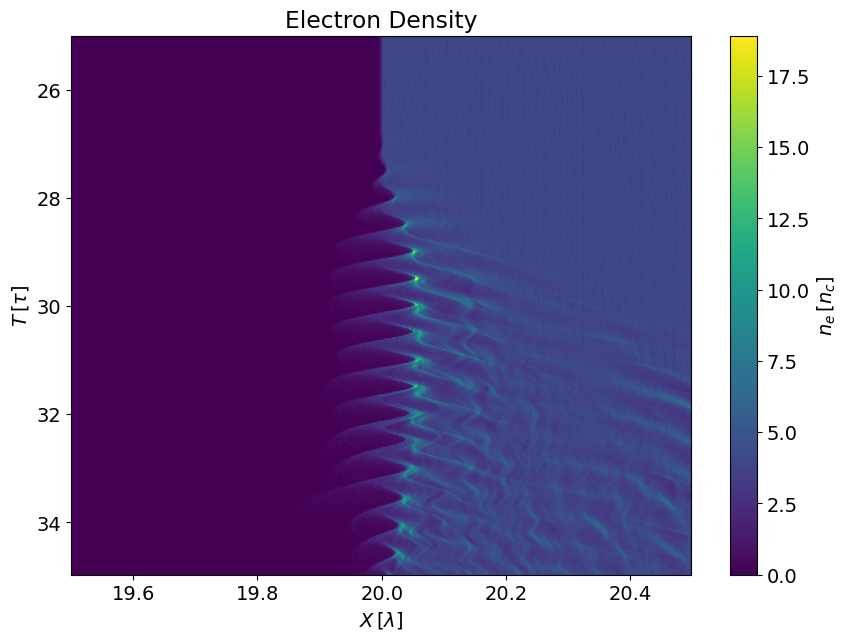

In [11]:

time_range =(25, 35)
space_range = (19.5, 20.5)
space_are_nodes = False
time_are_nodes = False
fig, ax = ez.plot_density_image(
    normalize=True,
    time_range=time_range,
    space_range=space_range,
    space_are_nodes=space_are_nodes,
    times_are_nodes=time_are_nodes,
    show_fig=True,
    aspect="auto",

)

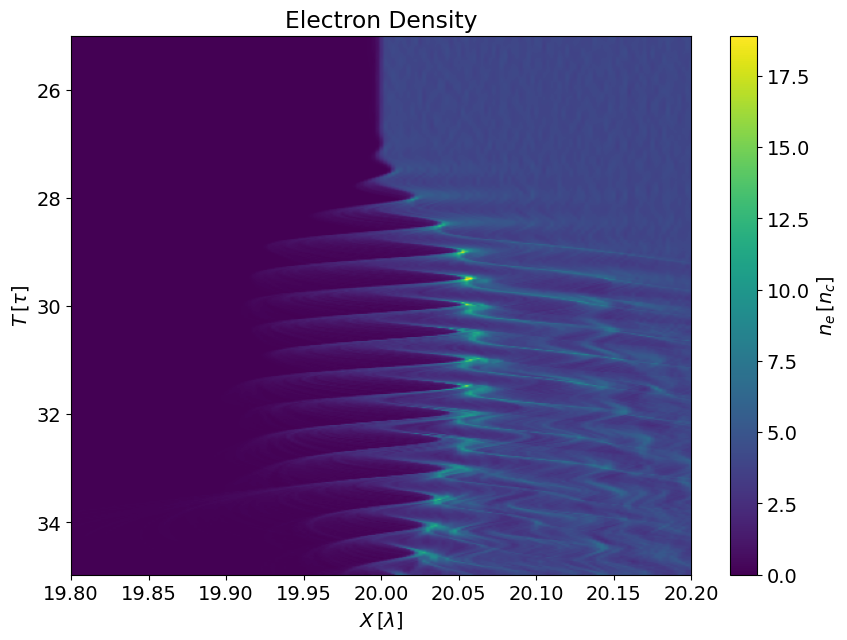

In [13]:
ax.set_xlim(19.8, 20.2)
fig

In [15]:
data, T, X = ez.load_data(
    data_types = ["Ey", "Ez"],
    normalize=True,
    time_range = None,
    space_range= [7800, 8000],
    times_are_nodes=False,
    space_are_nodes=True,
    return_data=True,
)

Loading Data...: 100%|██████████| 1669/1669 [00:28<00:00, 59.49it/s]


In [2]:
c = 3*1e8
e = 1.6*1e-19
m=9.1*1e-31
lambda0 = 1e-6
tau=lambda0/c
las_time = 20*tau
omega0 = 2*np.pi*c/lambda0
Er = m * omega0 * c / e
nx = 16000
t_end =40*tau
dt_snapshot = 0.08e-15
x_min = -20*lambda0
x_max = 20*lambda0
factor =4
epsilon = 8.85418782e-12
nc = epsilon*m*omega0**2/e**2
n0 = factor*nc

## Envelope

The envelope of the incident laser field varies according to
$$
    P(t)=
    \begin{cases}
         & exp\left({\frac{-(t-T/2)^p}{(0.15*T)^p}}\right) \text{ for } 0 \leq t \le T \\
         & 0         \;      \text{ otherwise }
    \end{cases}
$$
$$p=4$$

In [3]:
t_max = las_time
samples = 1000

In [4]:
def supr_gaus_env(t,p):
    if t<las_time:
        n=(t-0.5*las_time)**p
        d = (0.15*las_time)**p
        a  = np.sin(2*np.pi*t/tau)
        
        return a*np.exp(-(n/d))
    else:
        return 0

In [5]:
samples = 1000
t_max = las_time
t = np.linspace(0, t_max, samples)
gaus_list=[]
for time in t :
    gaus_list.append(supr_gaus_env(time,6))

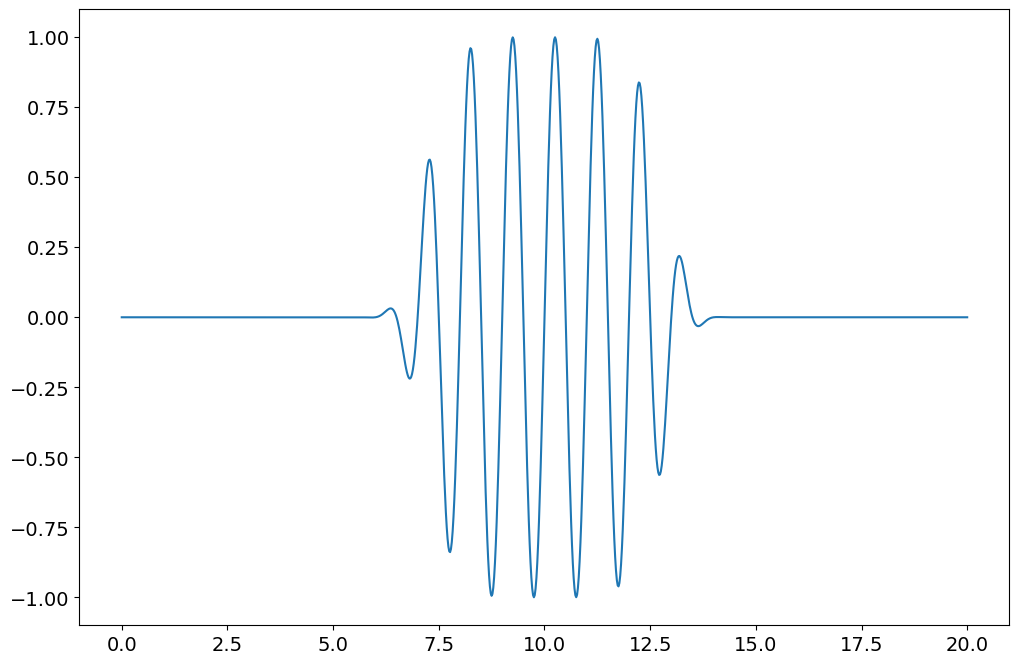

In [6]:
plt.plot(t/tau, gaus_list)

FFT of the envelope

In [7]:
# Want to resolve frequecy
f0 = omega0/(2*np.pi)
f0,omega0

(300000000000000.0, 1884955592153876.0)

Want to resolve frequecy 

omega0 = 1884955592153876.0

f0 = omega0/(2*np.pi) 

f0 = 300000000000000.0

min sample frequency = 2*f0 = 600000000000000.0

dt_max = 1/2*f0 = 1.6666666666666667e-15

our dt must be less than dt_max while fourier transformation for resolution of frequency omega0
dt = 6.666666666666667e-17



In [8]:
dt_max = 1/(2*f0)
dt_max

1.6666666666666666e-15

In [9]:
dt = t_max/samples
f_max = 1/dt
f = np.linspace(-f_max/2, f_max/2, samples)
omega_fft = 2*np.pi*f

In [10]:
gaus_fft = np.fft.fftshift(np.fft.fft(gaus_list))

(0.0, 5.0)

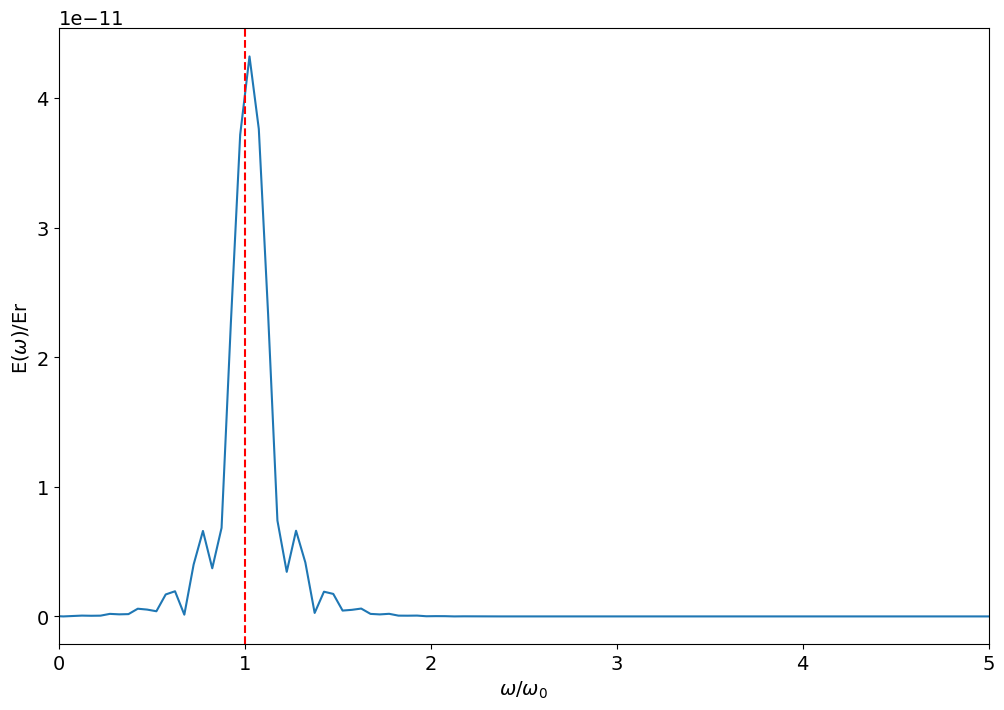

In [11]:
plt.plot(omega_fft/omega0, np.abs(gaus_fft)/Er)
plt.xlabel(r'$\omega/\omega_0$')
plt.ylabel('E($\omega$)/Er')
plt.axvline(x=1, color='r', linestyle='--')
plt.xlim(0, 5)

(0.0, 5.0)

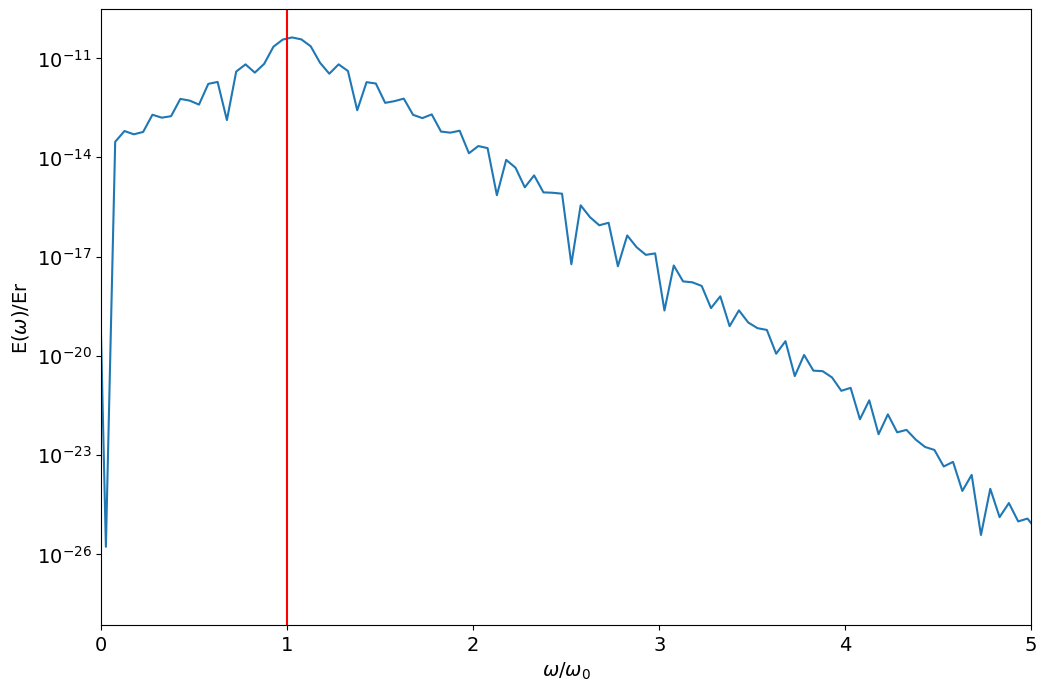

In [12]:
from matplotlib.lines import lineStyles


plt.plot(omega_fft/omega0, np.abs(gaus_fft)/Er)
plt.xlabel(r'$\omega/\omega_0$')
plt.ylabel('E($\omega$)/Er')
plt.yscale('log')
plt.axvline(1,color='r')
plt.xlim(0, 5)

## Simulation

The maximum time step for resolution of the frequency must be 

In [13]:
omega_to_resolve = 20*omega0
f_to_resolve = omega_to_resolve/(2*np.pi)
min_sampling_freq = 2*f_to_resolve
dt_max_to_resolve = 1/(min_sampling_freq)
print(f"The maximum time step for resolution is {dt_max_to_resolve*1e15: .3f} femto seconds")

The maximum time step for resolution is  0.083 femto seconds


so we take 

dt_snapshot = 0.08 femto seconds

so for fft

f_max = 1/dt_snapshot = 12.5 GHz

omega_max = 2*np.pi*f_max = 78.53981633974483

In [14]:
files = glob.glob('../Diff_laser_env/SG/p_4/*.sdf')
files.sort()
len(files)

1669

In [15]:
# data at time  = 100*dt_snapshot=8e-15 
all_data=sdf.read(files[100])
all_data.Electric_Field_Ey.data.shape

(16000,)

In [16]:
den = all_data.Derived_Number_Density_Electron.data

### Density Plot

Text(0, 0.5, 'n/n$_c$')

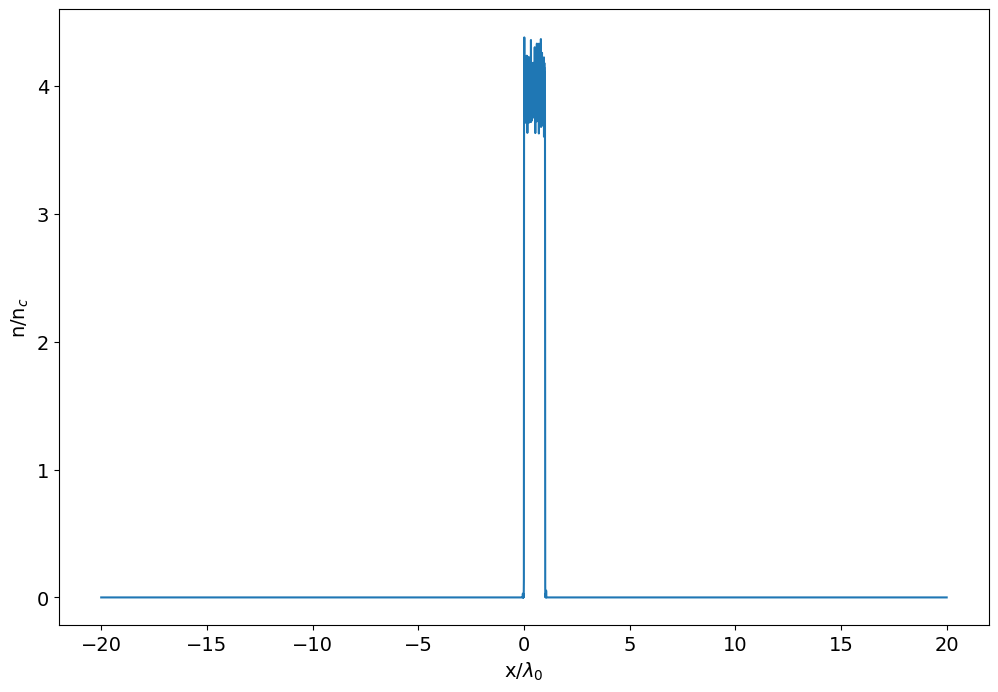

In [17]:
x = np.linspace(x_min, x_max, nx)
t = np.linspace(0, t_end, len(files))
plt.plot(x/lambda0,den/nc)
plt.xlabel('x/$\lambda_0$')
plt.ylabel('n/n$_c$')
# plt.figure(figsize=(12,10))

field at node 0,4000,8000,10000

In [18]:
Ey_0=[]
Ey_4000=[]
Ey_8000=[]
Ey_10000=[]
for f in tqdm.tqdm(files,desc='Reading files'):
    E=sdf.read(f).Electric_Field_Ey.data

    # Ey_0.append(E[0])
    # Ey_4000.append(E[4000])
    Ey_8000.append(E[8000])
    # Ey_10000.append(E[10000])
    


Reading files: 100%|██████████| 1669/1669 [00:41<00:00, 40.26it/s]


In [19]:
# Ey_0 = np.array(Ey_0)
# Ey_4000 = np.array(Ey_4000)
Ey_8000 = np.array(Ey_8000)
# Ey_10000 = np.array(Ey_10000)

Text(0.5, 1.0, 'Ey at 8000th Node')

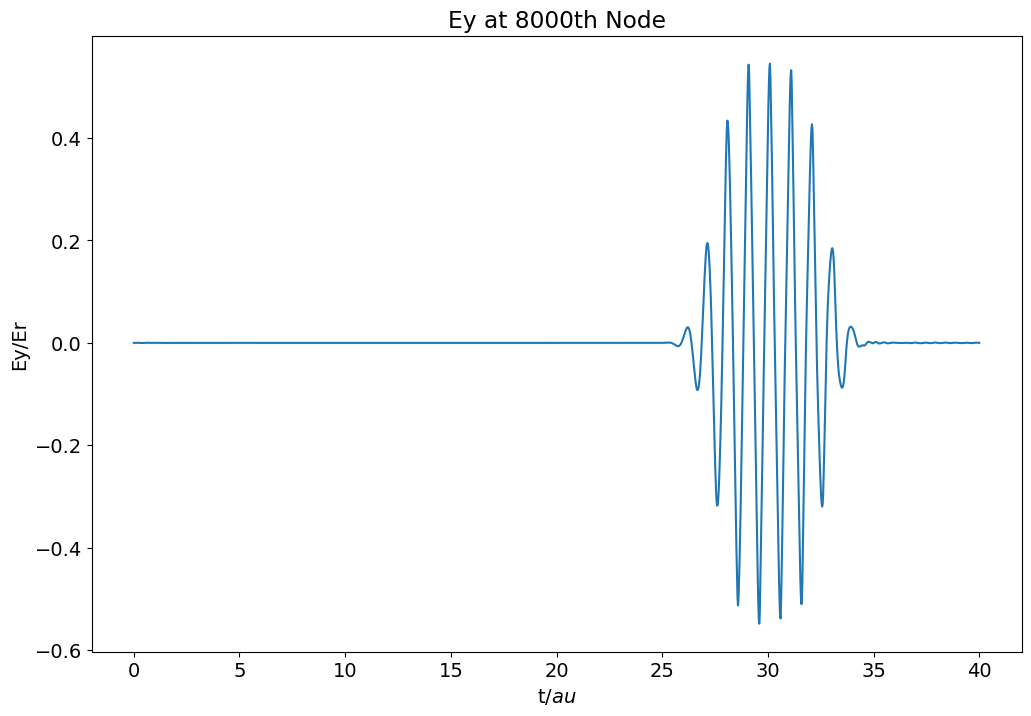

In [20]:
plt.plot(t/tau, Ey_8000/Er)
plt.xlabel('t/$\tau$')
plt.ylabel('Ey/Er')
plt.title('Ey at 8000th Node')

## FFT

In [21]:
f_max = 1/dt_snapshot
samples = len(files)
f = np.linspace(-f_max/2, f_max/2, samples)
omega_fft = 2*np.pi*f


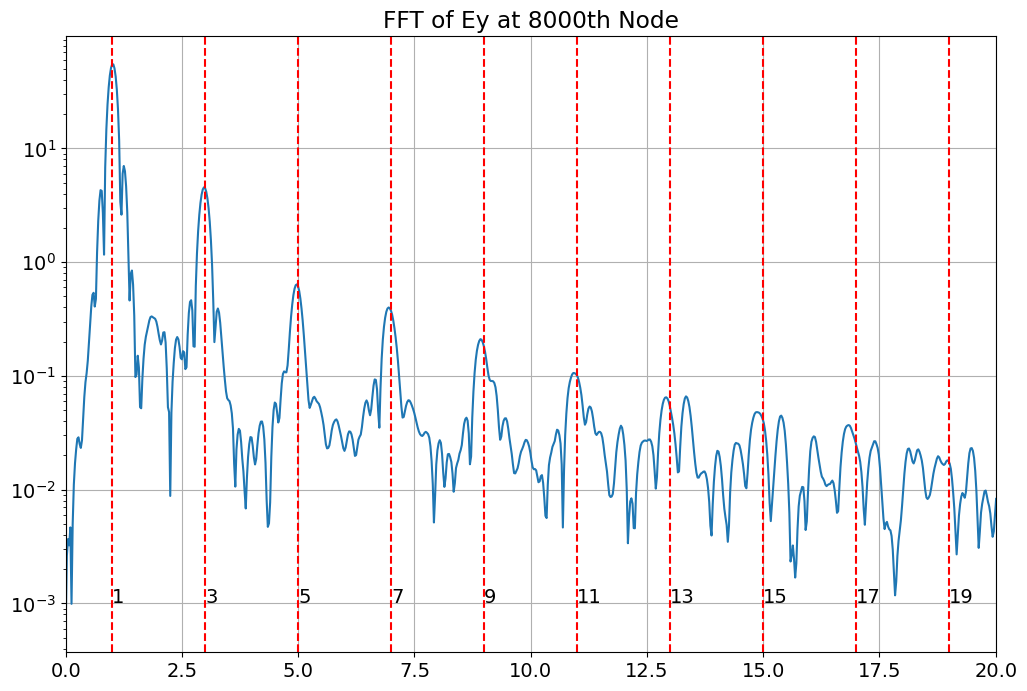

In [22]:
Ey_8000_fft = np.fft.fft(Ey_8000)
Ey_8000_fft = np.fft.fftshift(Ey_8000_fft)
# plt.figure(dpi=300)
plt.plot(omega_fft/omega0, np.abs(Ey_8000_fft)/Er)
plt.xlim(0,20)
plt.title('FFT of Ey at 8000th Node')
plt.yscale("log")
plt.grid()
for i in range(1,20,2):
    plt.axvline(i, color='r', linestyle='--')
    plt.annotate(f"{i}",  (i, 1e-3),color='black')
plt.show()

In [23]:
len(files)
print("len(files): ",len(files))
arr = np.zeros((len(files),16000))
arr = np.zeros((len(files),16000))
for t in range(0,len(files)):
    arr[t]=sdf.read(files[t]).Derived_Number_Density_Electron.data

print('arr.shape:',arr.shape)


len(files):  1669
arr.shape: (1669, 16000)


In [24]:
EXTENT = [-20, 20, 40, 0]

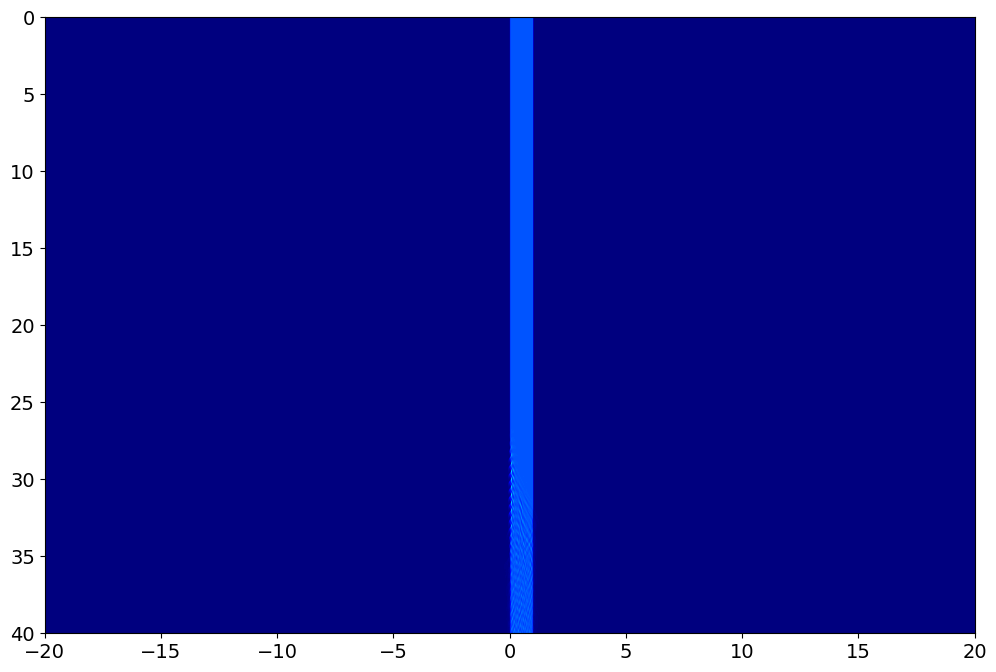

In [25]:
plt.imshow(arr[:, :], extent=EXTENT, aspect="auto", cmap="jet")
# plt.colorbar()

In [26]:
EXTENT = [-0.25, 0.25, 20, 40]

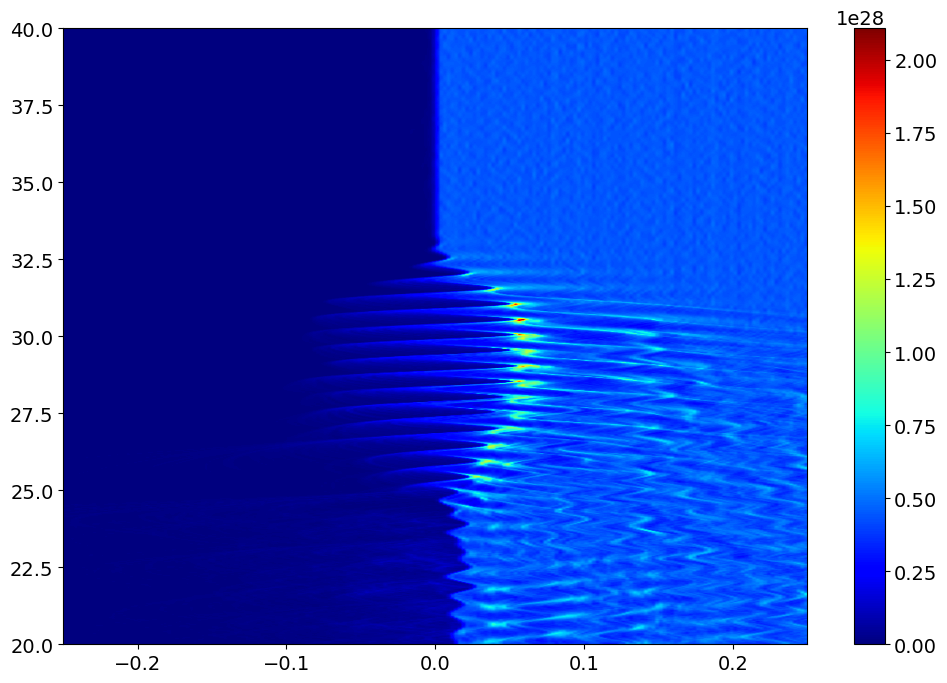

In [27]:
plt.imshow(arr[835:, 7900:8100], extent=EXTENT, aspect="auto", cmap="jet")
plt.colorbar()

In [28]:
# t_start = 1300
# t_end = 1500
# t_max = arr.shape[0]
# x_max = arr.shape[1]
# x_start = 2*3950
# x_end = 2*4100
# EXTENT = [-X_MIN*(x_start-NX//2)/x_max,-X_MIN*(x_end-NX//2)/x_max,T_MAX*t_end/t_max,T_MAX*t_start/t_max]
# plt.imshow(d[t_start:t_end, x_start:x_end], aspect="auto", extent=EXTENT, cmap="jet")
# cmap = colors.ListedColormap(["white"])
# plt.colorbar(cmap=cmap)